In [ ]:
#!pip install qlearnkit['pennylane']
#!pip install --upgrade scipy pennylane
#!pip install pennylane
#!pip install --upgrade numpy pennylane
#!pip install pennylane-lightning

In [ ]:
import torch
import torch.nn as nn
import pennylane as qml
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
class QLSTM(nn.Module):

    def custom_encoding(self, inputs, wires):
        # Apply Hadamard to each qubit to create an unbiased initial state
        for wire in range(self.n_qubits):
            qml.Hadamard(wires=wire)

        qml.templates.AngleEmbedding(torch.sin(inputs), rotation='Y', wires=wires)
        qml.templates.AngleEmbedding(torch.cos(inputs ** 2), rotation='Z', wires=wires)


    def custom_entangler_layer(self, weights, wires):
        for l in range(self.n_qlayers):  # Repeat the sequence twice
            # Apply CNOTs for the specified entanglement structure
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[1, 2])
            qml.CNOT(wires=[2, 3])
            qml.CNOT(wires=[3, 0])
            qml.CNOT(wires=[0, 2])
            qml.CNOT(wires=[1, 3])
            qml.CNOT(wires=[2, 0])
            qml.CNOT(wires=[3, 1])
            #print("Weights shape:", weights.shape)


            # Apply general rotation for each qubit
            for i, wire in enumerate(wires):
                qml.Rot(*weights[l, i, :], wires=wire)



    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=4,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        self.wires_forget = list(range(self.n_qubits))
        self.wires_input = list(range(self.n_qubits))
        self.wires_update = list(range(self.n_qubits))
        self.wires_output = list(range(self.n_qubits))
        self.wires_hidden = list(range(self.n_qubits))
        self.wires_output_pre = list(range(self.n_qubits))

        self.dev_forget = qml.device('default.qubit', wires=self.wires_forget)
        self.dev_input = qml.device('default.qubit', wires=self.wires_input)
        self.dev_update = qml.device('default.qubit', wires=self.wires_update)
        self.dev_output = qml.device('default.qubit', wires=self.wires_output)
        self.dev_hidden = qml.device('default.qubit', wires=self.wires_hidden)
        self.dev_output_pre = qml.device('default.qubit', wires=self.wires_output_pre)



        def _circuit_forget(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_forget)
            self.custom_entangler_layer(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_input)
            self.custom_entangler_layer(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_update)
            self.custom_entangler_layer(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output)
            self.custom_entangler_layer(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        def _circuit_hidden(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_hidden)
            self.custom_entangler_layer(weights, wires=self.wires_hidden)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_hidden]
        self.qlayer_hidden = qml.QNode(_circuit_hidden, self.dev_hidden, interface="torch")

        def _circuit_output_pre(inputs, weights):
            self.custom_encoding(inputs, wires=self.wires_output_pre)
            self.custom_entangler_layer(weights, wires=self.wires_output_pre)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output_pre]
        self.qlayer_output_pre = qml.QNode(_circuit_output_pre, self.dev_output_pre, interface="torch")

        weight_shapes = {"weights": (self.n_qlayers, self.n_qubits, 3)}
        print(f"weight_shapes = (n_qlayers, n_qubits, 3) = ({n_qlayers}, {n_qubits}, 3)")

        self.clayer_in = torch.nn.Linear(self.hidden_size + self.n_inputs, self.n_qubits)
        print("Initialized clayer_in weight shape:", self.clayer_in.weight.shape)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes),
            'hidden': qml.qnn.TorchLayer(self.qlayer_hidden, weight_shapes),
            'output_pre': qml.qnn.TorchLayer(self.qlayer_output_pre, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:

            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)
            #print("Shape of concatenated input v_t:", v_t.shape)
            #print("Weight shape of clayer_in:", self.clayer_in.weight.shape)
            # match qubit dimension

            v_t = self.clayer_in(v_t)
            #print("Shape after clayer_in:", v_t.shape)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](v_t)))
            #print("Shape of forget block output:", f_t.shape)  # forget block

            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](v_t)))
            #print("Shape of input block output:", i_t.shape)   # input block

            g_t = torch.tanh(self.clayer_out(self.VQC['update'](v_t)))
            c_t = (f_t * c_t) + (i_t * g_t)

            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](v_t)))
            #print("Shape of output block output:", o_t.shape) # output block

            h_t = self.VQC['hidden'](o_t * torch.tanh(c_t))
            y_tilde = self.VQC['output_pre'](o_t * torch.tanh(c_t))
            y_t = self.clayer_out(y_tilde)

            hidden_seq.append(h_t.unsqueeze(0))

        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset
from scipy import integrate


def solve_lorenz(N=10, max_time=4.0, sigma=10.0, beta=8./3, rho=28.0):
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]
    np.random.seed(1)
    x0 = -15 + 30 * np.random.random((N, 3))
    t = np.linspace(0, max_time, int(100*max_time))
    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t) for x0i in x0])
    return x_t

batch_size = 64

# Normalize the data
def normalize_data(data):
    data_min = np.min(data, axis=(0, 1), keepdims=True)
    data_max = np.max(data, axis=(0, 1), keepdims=True)
    return 2 * (data - data_min) / (data_max - data_min) - 1, data_min, data_max

def denormalize(norm_data, data_min, data_max):
    """Denormalize the data from the [-1, 1] range back to its original scale."""
    return norm_data * (data_max - data_min) / 2 + (data_max + data_min) / 2


# Prepare sequences similarly to Van der Pol example
def prepare_sequences(data, seq_length):
    num_samples, _, _ = data.shape
    input_size = data.shape[2]  # Number of features, which is 3 for x, y, z
    xs, ys = [], []
    for sequence in data:
        for i in range(len(sequence) - seq_length):
            xs.append(sequence[i:(i + seq_length)])
            ys.append(sequence[i + seq_length])
    return np.array(xs), np.array(ys)

# Adjusted main code flow
data = solve_lorenz()
data_normalized, data_min, data_max = normalize_data(data)

seq_length = 10  # Number of time steps in each sequence
X, y = prepare_sequences(data_normalized, seq_length)

# Splitting data into training and testing sets
train_size = int(0.67 * len(X))
test_size = len(X) - train_size

# Split the normalized data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

# Create DataLoaders
batch_size = 256  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


LSTM hidden layer size: 4
Number of qubits: 0
Training epochs: 20
Learning rate: 0.02
RMSprop alpha: 0.99
RMSprop eps: 1e-08
input size: 3
Tagger will use Classical LSTM
Total number of trainable parameters: 159
Length of train_data: 2613
Epoch 1, Train Loss: 0.08473268, Test Loss: 0.07348734
Epoch 2, Train Loss: 0.04937150, Test Loss: 0.03907776
Epoch 3, Train Loss: 0.02905423, Test Loss: 0.03293542
Epoch 4, Train Loss: 0.02451506, Test Loss: 0.01736368
Epoch 5, Train Loss: 0.01617306, Test Loss: 0.01285970
Epoch 6, Train Loss: 0.01398291, Test Loss: 0.01250801
Epoch 7, Train Loss: 0.01214842, Test Loss: 0.01510266
Epoch 8, Train Loss: 0.01184085, Test Loss: 0.01605816
Epoch 9, Train Loss: 0.01003340, Test Loss: 0.01234124
Epoch 10, Train Loss: 0.00704502, Test Loss: 0.00803128
Epoch 11, Train Loss: 0.00645042, Test Loss: 0.00692451
Epoch 12, Train Loss: 0.00765927, Test Loss: 0.00687647
Epoch 13, Train Loss: 0.00642267, Test Loss: 0.00743645
Epoch 14, Train Loss: 0.00539306, Test Los

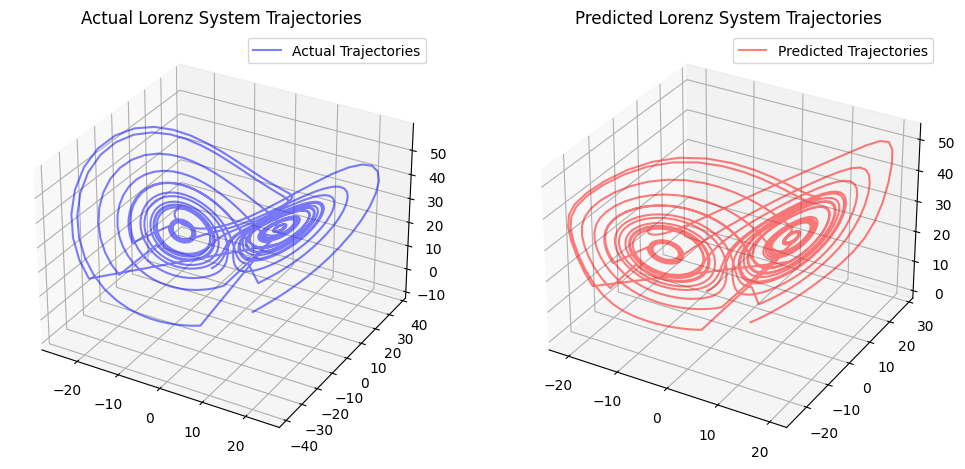

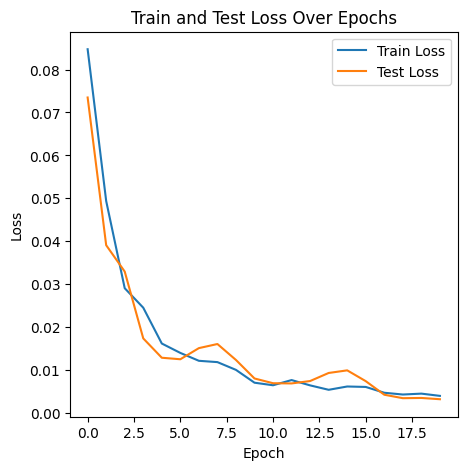

In [ ]:
from scipy.integrate import solve_ivp
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Subset

class LSTMTagger(nn.Module):
    def __init__(self, input_size, hidden_dim, sequence_length, n_qubits=0, num_layers=1, output_size=1, backend='default.qubit'):
        """
        Initialize the LSTMTagger model.
        Args:
            input_size (int): The number of input features.
            hidden_dim (int): The size of the hidden layer.
            sequence_length (int): The length of the input sequences.
            n_qubits (int, optional): The number of qubits for the Quantum LSTM. Defaults to 0 for Classical LSTM.
            output_size (int): The size of the output layer.
            num_layers (int): The number of layers in the LSTM.
            backend (str): The backend for Quantum LSTM. Ignored for Classical LSTM.
        """
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # Choose between Quantum LSTM and Classical LSTM based on n_qubits
        if n_qubits > 0:
            print(f"Tagger will use Quantum LSTM running on backend {backend}")
            self.lstm = QLSTM(input_size, hidden_dim, n_qubits=n_qubits)  # Assuming QLSTM is defined elsewhere
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        """
        Define the forward pass of the LSTMTagger.
        Args:
            x (Tensor): The input tensor to the model.
        Returns:
            Tensor: The output of the model.
        """
        # Pass the input through the LSTM layer
        lstm_out, _ = self.lstm(x)

        # Extract the last time step for each sequence in the batch
        last_timestep_output = lstm_out[:, -1, :]

        # Pass the last time step through the linear layer
        fc_out = self.fc(last_timestep_output)

        return fc_out




class Args:
    hidden_dim = 4
    n_qubits = 0
    n_epochs = 20
    backend = 'default.qubit'
    learning_rate = 0.02
    alpha = 0.99
    eps = 1e-8
    input_size = 3
args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"LSTM hidden layer size: {args.hidden_dim}")
print(f"Number of qubits: {args.n_qubits}")
print(f"Training epochs: {args.n_epochs}")
print(f"Learning rate: {args.learning_rate}")
print(f"RMSprop alpha: {args.alpha}")
print(f"RMSprop eps: {args.eps}")
print(f"input size: {args.input_size}")




# Instantiate LSTMTagger model with parameters from Args class
model = LSTMTagger(input_size=args.input_size,
                   hidden_dim=args.hidden_dim,
                   sequence_length=10,
                   n_qubits=args.n_qubits,
                   output_size=args.input_size,  # Output size is same as input size for next step prediction
                   backend=args.backend).float()

# Calculate and print the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

# Define the loss function and optimizer
loss_function = torch.nn.MSELoss()
#optimizer = torch.optim.RMSprop(model.parameters(), lr=args.learning_rate, alpha=args.alpha, eps=args.eps)
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, betas=(0.99, 0.9999), eps=args.eps, weight_decay=1e-3)



print("Length of train_data:", len(train_loader.dataset))

train_losses = []
test_losses = []



for epoch in range(1, args.n_epochs + 1):
    model.train()  # Set model to training mode
    epoch_train_losses = []

    # Iterate through batches provided by train_loader
    for inputs, labels in train_loader:

        #print("Batch input shape:", inputs.shape)  # Expected: [batch_size, seq_length, input_size]
        #print("Batch labels shape:", labels.shape)

        optimizer.zero_grad()
        outputs = model(inputs)

        #print("Batch output shape:", outputs.shape)

        # The outputs shape is expected to match the labels shape here
        loss = loss_function(outputs, labels)

        #print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)  # Track average train loss

    # Evaluation on test data using test_loader
    model.eval()  # Set model to evaluation mode
    epoch_test_losses = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            epoch_test_losses.append(loss.item())

    avg_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(avg_test_loss)  # Track average test loss

    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.8f}, Test Loss: {avg_test_loss:.8f}")


# Predict and evaluate
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    # Predictions for the training and testing datasets
    train_pred_raw = model(train_loader.dataset.tensors[0])
    test_pred_raw = model(test_loader.dataset.tensors[0])

    # Denormalize predictions
    train_pred = denormalize(train_pred_raw.numpy(), data_min, data_max)
    test_pred = denormalize(test_pred_raw.numpy(), data_min, data_max)

    # Denormalize actual data
    train_actual = denormalize(train_loader.dataset.tensors[1].numpy(), data_min, data_max)
    test_actual = denormalize(test_loader.dataset.tensors[1].numpy(), data_min, data_max)

    # Metrics calculation for each dimension
    for dim in range(3):  # Loop through x, y, z dimensions
        # Training metrics
        mae_train = mean_absolute_error(train_actual[:, dim], train_pred[:, dim])
        rmse_train = np.sqrt(mean_squared_error(train_actual[:, dim], train_pred[:, dim]))

        # Testing metrics
        mae_test = mean_absolute_error(test_actual[:, dim], test_pred[:, dim])
        rmse_test = np.sqrt(mean_squared_error(test_actual[:, dim], test_pred[:, dim]))

        print(f"Dimension {dim+1} (x,y,z) - Train MAE: {mae_train:.4f}, Train RMSE: {rmse_train:.4f}, Test MAE: {mae_test:.4f}, Test RMSE: {rmse_test:.4f}")

if train_actual.ndim > 2 or train_pred.ndim > 2:
    # Assuming the first dimension is the number of samples
    train_actual = train_actual.reshape(-1, train_actual.shape[-1])
    train_pred = train_pred.reshape(-1, train_pred.shape[-1])

# Visualization
fig = plt.figure(figsize=(12, 6))

# Plot actual trajectories
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(train_actual[:, 0], train_actual[:, 1], train_actual[:, 2], color='blue', alpha=0.5, label='Actual Trajectories')
ax1.set_title("Actual Lorenz System Trajectories")
ax1.legend()

# Plot predicted trajectories
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(train_pred[:, 0], train_pred[:, 1], train_pred[:, 2], color='red', alpha=0.5, label='Predicted Trajectories')
ax2.set_title("Predicted Lorenz System Trajectories")
ax2.legend()

plt.show()

# Plotting training and test losses over epochs
plt.figure(figsize=(5, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Train and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(1, 1287, 3)
(1, 1287, 3)


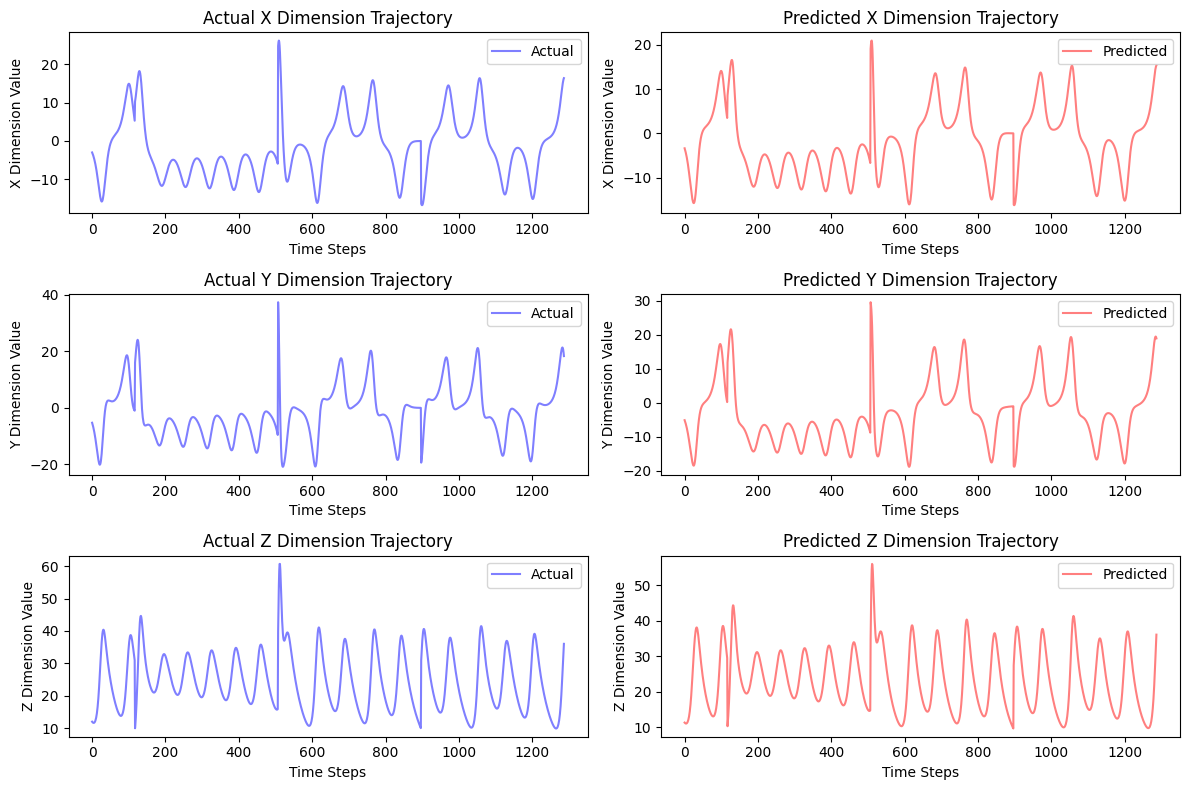

In [ ]:
all_predictions = []
all_actuals = []

# Define the denormalization function
def denormalize(norm_data, data_min, data_max):
    return norm_data * (data_max - data_min) / 2 + (data_min + data_max) / 2

model.eval()  # Ensure the model is in evaluation mode

with torch.no_grad():
    for seq, actual in test_loader:
        predicted = model(seq)  # Generate predictions

        # Store predictions and actuals
        all_predictions.extend(predicted.numpy())
        all_actuals.extend(actual.numpy())

# Convert lists to numpy arrays for easier handling
all_predictions = np.array(all_predictions)
all_actuals = np.array(all_actuals)


all_predictions_denorm = denormalize(all_predictions, data_min, data_max)
all_actuals_denorm = denormalize(all_actuals, data_min, data_max)
print(all_predictions_denorm.shape)
print(all_actuals_denorm.shape)

all_predictions_squeezed = all_predictions_denorm.squeeze(0)
all_actuals_squeezed = all_actuals_denorm.squeeze(0)



# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8), dpi=100)

# Titles for plots
titles = ['X Dimension', 'Y Dimension', 'Z Dimension']

for i in range(3):
    # Actual trajectories
    axes[i][0].plot(all_actuals_squeezed[:, i], color='blue', alpha=0.5, label='Actual')
    axes[i][0].set_title(f"Actual {titles[i]} Trajectory")
    axes[i][0].set_xlabel('Time Steps')
    axes[i][0].set_ylabel(f'{titles[i]} Value')
    axes[i][0].legend(loc='upper right')

    # Predicted trajectories
    axes[i][1].plot(all_predictions_squeezed[:, i], color='red', alpha=0.5, label='Predicted')
    axes[i][1].set_title(f"Predicted {titles[i]} Trajectory")
    axes[i][1].set_xlabel('Time Steps')
    axes[i][1].set_ylabel(f'{titles[i]} Value')
    axes[i][1].legend(loc='upper right')

plt.tight_layout()
plt.show()